In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
N = 10000
d = 4
n_train = int(N * 0.8)
n_val = int(N * 0.2)

# Simulate a dataset

In [3]:
np.random.seed(9345)

In [4]:
x = np.random.normal(size=(N,1))

In [5]:
def noisy_polynomial(x):
    n = len(x)
    a = np.random.choice(range(1, 4))
    b = np.random.choice(range(1, 3))
    c = np.random.normal(size=(n,))
    return np.power(x, a) + np.power(x, b) + x + c

In [6]:
for _ in range(d - x.shape[1]):
    # All added columns are dependent on the first column
    x = np.column_stack((x, noisy_polynomial(x[:,0])))

In [7]:
x_df = pd.DataFrame(x[1:1000], columns=[str(c) for c in range(x.shape[1])])

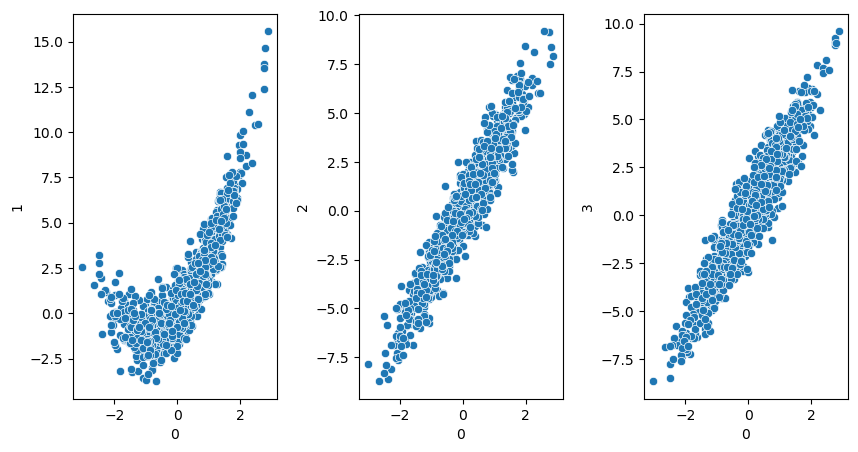

In [8]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 3, 1)
sns.scatterplot(x_df, x="0", y="1")
ax = fig.add_subplot(1, 3, 2)
sns.scatterplot(x_df, x="0", y="2")
ax = fig.add_subplot(1, 3, 3)
sns.scatterplot(x_df, x="0", y="3")
plt.show()


# Autoencoder

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_depth):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList()
        for _ in range(hidden_depth):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x


class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_depth):
        super().__init__()
        self.input_layer = nn.Linear(latent_dim, hidden_dim)
        self.hidden_layers = nn.ModuleList()
        for _ in range(hidden_depth):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.output_layer = nn.Linear(hidden_dim, input_dim)
        
    def forward(self, x):
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        return x


class AE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, hidden_depth=1):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, hidden_depth)
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim, hidden_depth)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
hidden_dim = x.shape[1] * 4
# Should be able to represent latent dimension well with 1-D
# since other dimensions are dependent on x[0]
latent_dim = 1

In [11]:
x_train = x[:n_train]
x_val = x[n_train:]

In [12]:
net = AE(
    input_dim=x.shape[1],
    hidden_dim=x.shape[1] * 4,
    latent_dim=1,
    hidden_depth=2
).to(device)

In [13]:
print(net)

AE(
  (encoder): Encoder(
    (input_layer): Linear(in_features=4, out_features=16, bias=True)
    (hidden_layers): ModuleList(
      (0-1): 2 x Linear(in_features=16, out_features=16, bias=True)
    )
    (output_layer): Linear(in_features=16, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (input_layer): Linear(in_features=1, out_features=16, bias=True)
    (hidden_layers): ModuleList(
      (0-1): 2 x Linear(in_features=16, out_features=16, bias=True)
    )
    (output_layer): Linear(in_features=16, out_features=4, bias=True)
  )
)


In [14]:
n_epochs = 200
batch_size = 128
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

In [15]:
for epoch in range(n_epochs):
    
    # Train
    net.train()
    total_train_loss = 0.0
    avg_train_loss = 0.0
    
    total_val_loss = 0.0
    avg_val_loss = 0.0

    
    for i, start in enumerate(range(0, x_train.shape[0], batch_size)):
        inputs = x_train[start:start + batch_size, :]
        inputs = torch.from_numpy(inputs).to(torch.float32).to(device)
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
        # Divide total loss by number of mini batches
        avg_train_loss = total_train_loss / (i + 1)
    if (epoch + 1) % 25 == 0 or epoch == 0:
        print(f"[{epoch + 1}] avg. train loss: {np.round(avg_train_loss, 3)}")

        # Validate
        with torch.no_grad():
            for i, start in enumerate(range(0, x_val.shape[0], batch_size)):
                inputs = x_val[start:start + batch_size, :]
                inputs = torch.from_numpy(inputs).to(torch.float32).to(device)

                outputs = net(inputs)
                loss = criterion(outputs, inputs)
                total_val_loss += loss.item()
                avg_val_loss = total_val_loss / (i + 1)
            print(f"[x] avg. val loss: {np.round(avg_val_loss, 3)}")
    


[1] avg. train loss: 6.897
[x] avg. val loss: 6.264
[25] avg. train loss: 0.522
[x] avg. val loss: 0.515
[50] avg. train loss: 0.516
[x] avg. val loss: 0.51
[75] avg. train loss: 0.51
[x] avg. val loss: 0.504
[100] avg. train loss: 0.5
[x] avg. val loss: 0.494
[125] avg. train loss: 0.486
[x] avg. val loss: 0.48
[150] avg. train loss: 0.473
[x] avg. val loss: 0.468
[175] avg. train loss: 0.462
[x] avg. val loss: 0.457
[200] avg. train loss: 0.458
[x] avg. val loss: 0.453
